In [2]:
# 1. Load & clean data

In [3]:
import os
import sys
import pandas
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
dir_path = os.getcwd()
file_path = fr"{dir_path}\\train.csv"

csvFile = pandas.read_csv(file_path)

C:\Users\Denys\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Denys\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Denys\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Denys\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

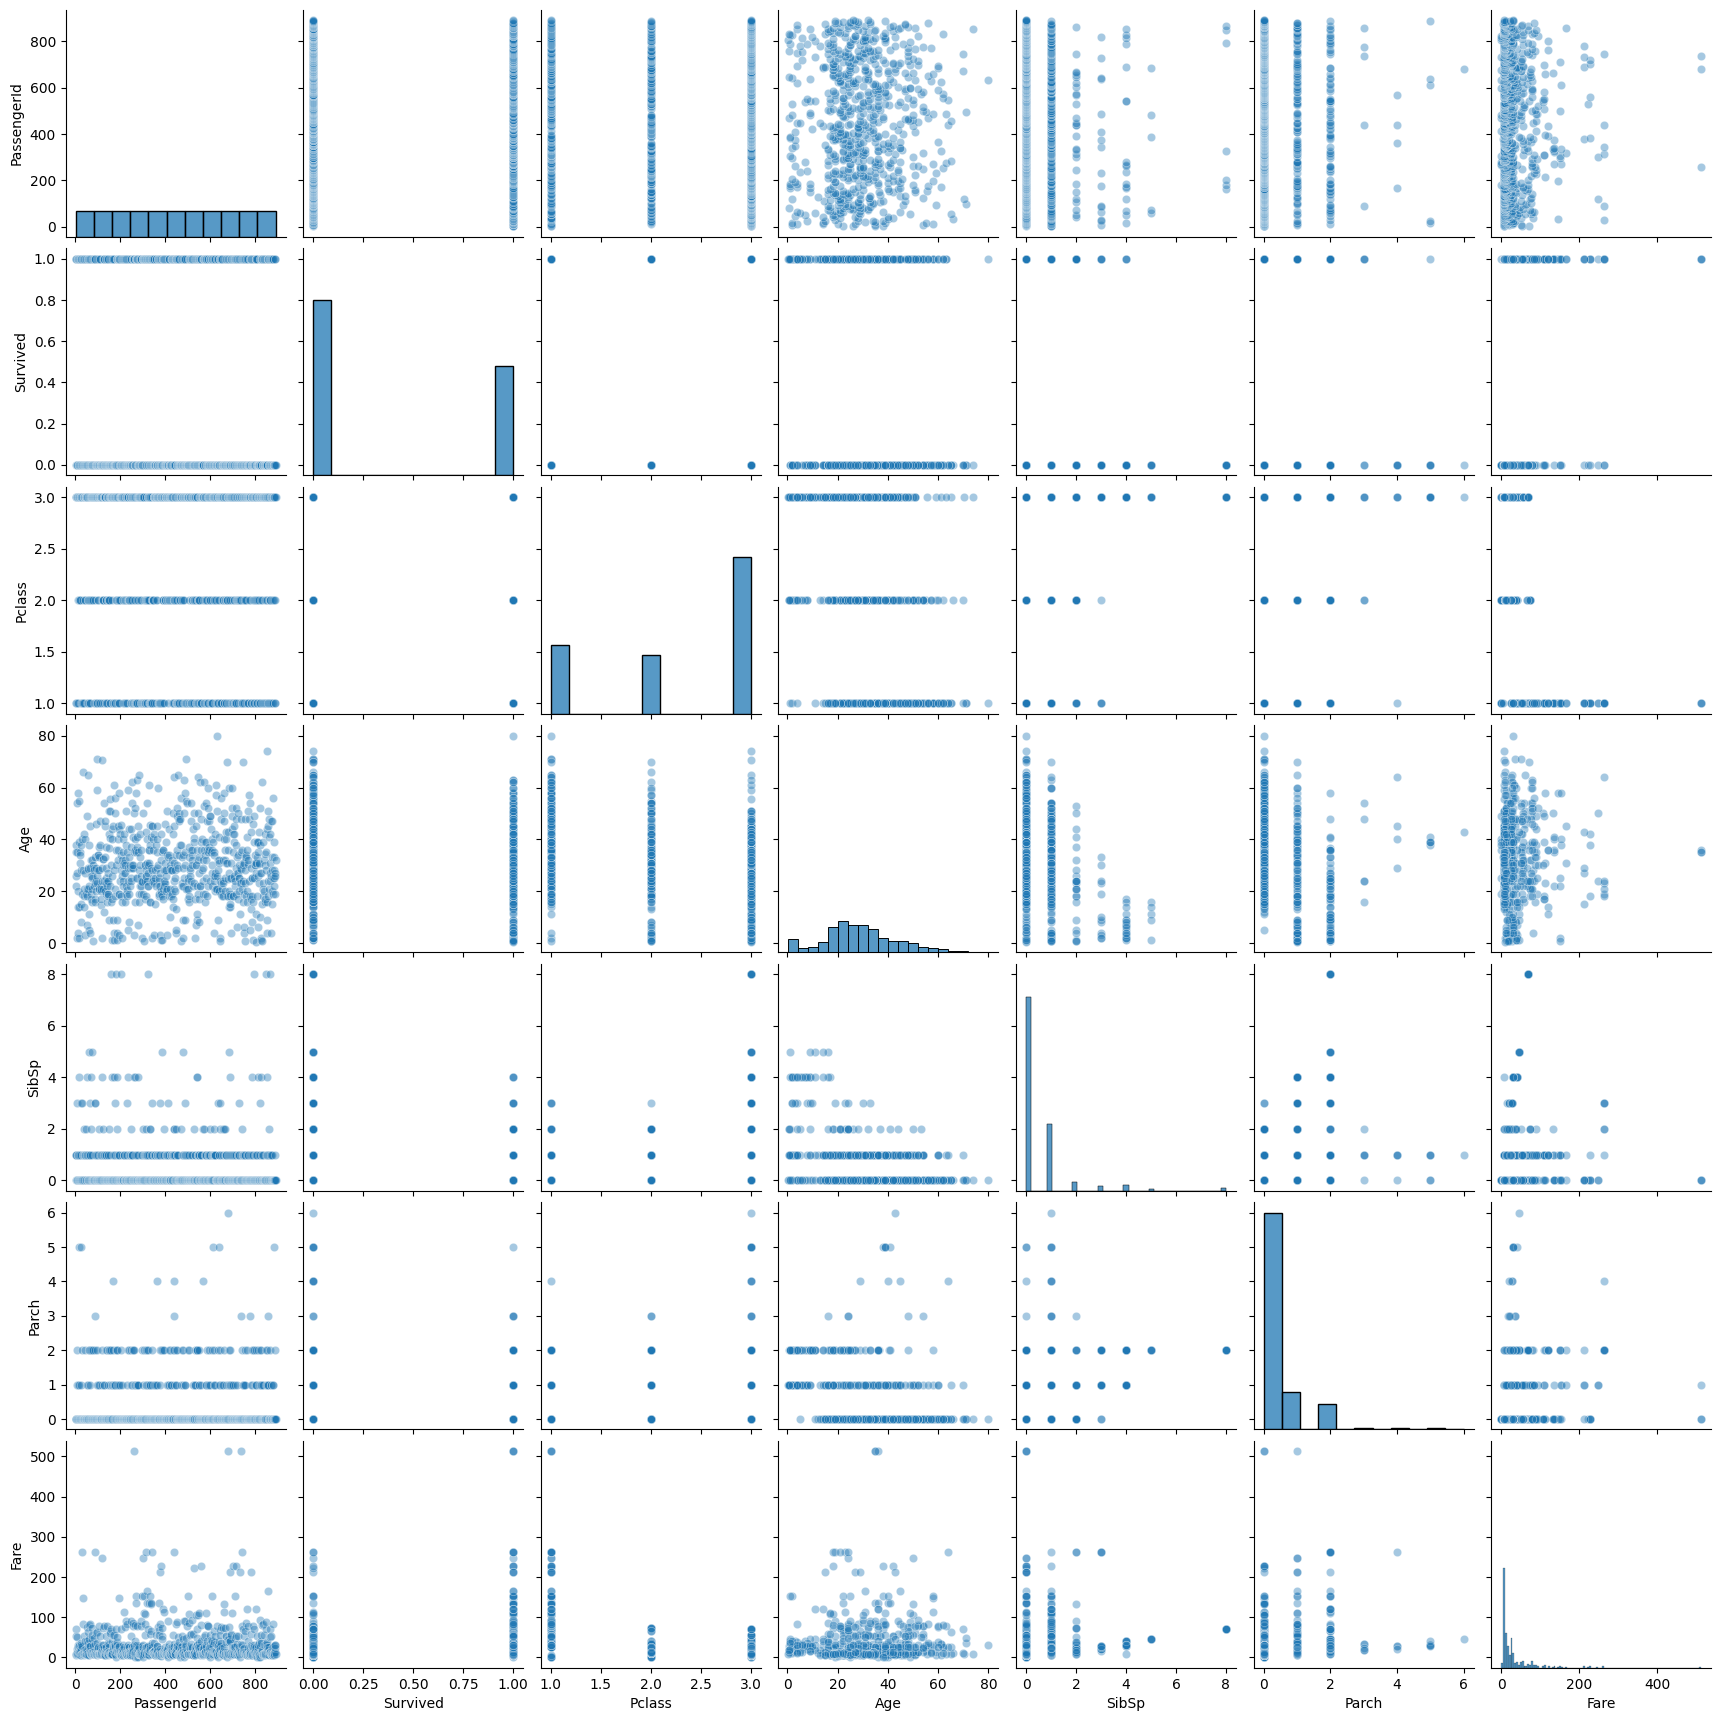

In [5]:
# seaborn to check any corrilations between variables
scatter_fig = sns.pairplot(csvFile, kind="scatter", plot_kws={"alpha":0.4})

In [6]:
print(csvFile.info())
print(csvFile.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

In [7]:
# 2. Feature engineering

# With respect to the family relation variables (i.e. sibsp and parch) some relations were ignored. The following are the definitions used for sibsp and parch.

# Sibling: Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
# Spouse: Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
# Parent: Mother or Father of Passenger Aboard Titanic
# Child: Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

#Questions?
# what is relation beetween family size and survival rate 
# what children < 18 survival rate 
# how survival rate depended on Cabin - level /   A- highest / B- 
                # A → верхня палуба (дуже дорогі каюти, 1-й клас)
                # C → середня палуба
                # E, F, G → нижчі палуби (2-й або 3-й класи)
                # NONE - no Cabin was written for 3 class


# important data column
# Pclass  Sex  Age   FamilySize 

# TODO 

# 3. Data scaling
# Clean dataset from null -> Age 714 non-null    float64
# Fade can be a sum for some tickets ( not for only one) all have same  ticket numbers


In [8]:
csvFile = pandas.read_csv(file_path)
titanic_ds = csvFile[csvFile["Age"].notnull()]

titanic_ds = titanic_ds.reset_index(drop=True)

count_of_dublicats = titanic_ds["Ticket"].value_counts()
tickets_dublicats = count_of_dublicats[count_of_dublicats > 1]

# devide price of ticket for each pass
for ticket, count in tickets_dublicats.items():
    # find which row belogs to ticket 
    #print(ticket) # 24160
    rows_same_ticket_id = titanic_ds[titanic_ds["Ticket"] == ticket]
    for row_number in rows_same_ticket_id.index:
        price = float(titanic_ds.loc[row_number, "Fare"])
        titanic_ds.loc[row_number, "Fare"] =  price / float(count) # rewrite price to single ticket
        if ticket == "24160":
            print(titanic_ds.loc[row_number, "Fare"])

titanic_ds["FamilySize"] = titanic_ds["SibSp"] + titanic_ds["Parch"] + 1 # add new column, family size looks like important

titanic_ds["Sex"] = titanic_ds["Sex"].map({"male": 0, "female": 1}) # get readout from string value in dataset - change male to 0 female to 1

70.44583333333334
70.44583333333334
70.44583333333334


children 113
children Survived 61


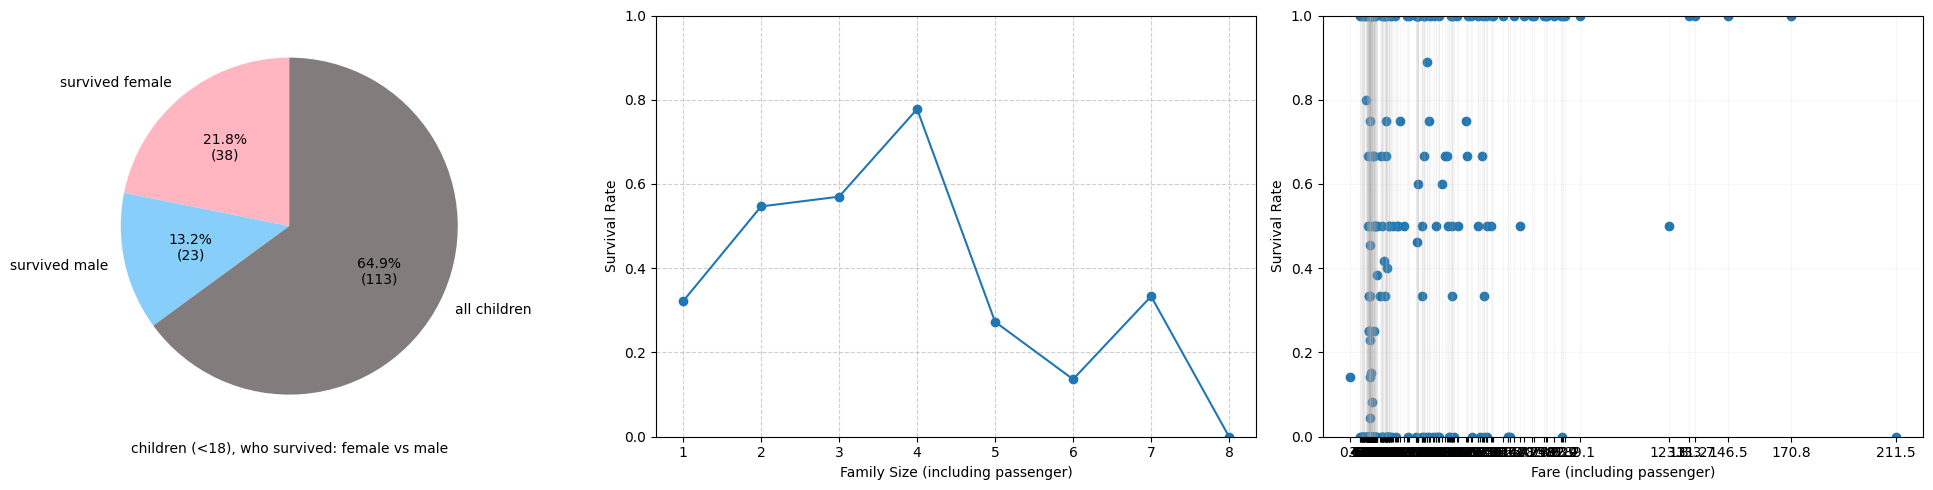

In [9]:
# children’s survival rate (<18) is a great way to understand age influence in the Titanic dataset.
children = titanic_ds[titanic_ds["Age"] < 18]
children_survival = children[children["Survived"] == 1]

print("children", len(children))
print("children Survived", len(children_survival))

counts = children_survival["Sex"].value_counts()

values = counts.values.tolist()
values.append(len(children))


def autopct_format(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute})"

fig, axes = plt.subplots(ncols=3, figsize=(20, 5))

axes[0].pie(
    values,
    labels=["survived female", 'survived male', 'all children'],
    autopct=lambda pct: autopct_format(pct, values),
    startangle=90,
    colors=["#FFB6C1", "#87CEFA", "#827c7d"],
)

axes[0].set_xlabel("children (<18), who survived: female vs male")

family_survival = titanic_ds.groupby("FamilySize")["Survived"].mean()

axes[1].plot(family_survival.index, family_survival.values, marker='o', linestyle='-')

axes[1].set_xlabel("Family Size (including passenger)")
axes[1].set_ylabel("Survival Rate")
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_xticks(family_survival.index)
axes[1].set_ylim(0, 1)


ticket_price_survival = titanic_ds.groupby("Fare")["Survived"].mean()

axes[2].scatter(ticket_price_survival.index, ticket_price_survival.values, marker='o',)

axes[2].set_xlabel("Fare (including passenger)")
axes[2].set_ylabel("Survival Rate")
axes[2].grid(True, alpha=0.1)
axes[2].set_xticks(ticket_price_survival.index)
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(fr"{dir_path}\docs\data_plot.png", dpi=300, bbox_inches="tight")
plt.show()


In [10]:
# create a NN with inputs

# 4. Model (NN / RandomForest / etc.)
#[Pclass  Sex   Age   Fare    FamilySize] - [Survived]  


In [11]:
print(titanic_ds.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

             Ticket     Fare Cabin Embarked  FamilySize  
0         A/5 21171   7.2500   NaN        S           2  
1          PC 17599  71.2833   C85        C           2  
2  STON/O2. 3101282   7.9250   NaN        S           1  
3            113803  26.5500  C123        S           2  
4     

In [12]:
training_data = []
training_goal = []
testing_data = []
testing_goal = []
# prepare data for learning 

# one row is a one data peace where first 4 colomns in input - last colomn is an output 
# devide dataset to training and testing data
# devided by 80/20
for iterator, data in titanic_ds.iterrows():
    input_data = [data["Pclass"], data["Sex"], data["Age"] / 100, data["Fare"] / 100, data["FamilySize"] / 10,]
    output_data = [data["Survived"]]
    if iterator % 5 == 0:
        testing_data.append(input_data)
        testing_goal.append(output_data)
    else:
        training_data.append(input_data)
        training_goal.append(output_data)

# print(testing_data)
#print("testing_data",len(testing_data))
#print("testing_goal",len(testing_goal))
#print("training_data",len(training_data))
#print("training_goal",len(training_goal))

In [13]:
# create a structure for neural network 

# 5 inputs neurons, one hidden layer with 7 neurons, one hidden layer with 5 neurons, 1 output layers

#       0   
#   0---0---0
#   0---0---0 
#   0---0---0----0   (0-1) live or death
#   0---0---0
#   0---0---0
#       0

In [14]:
def sigmoid(z): # used in last layer when binarry output iis needed
    return 1 / (1 + np.exp(-z))

def relu(z): # everything that bigger then 0 comes thought, used for hidden layers
    return np.maximum(0, z)

def relu_derivative(x):
    return (x > 0).astype(float)
    # ReLU «відрізає» від’ємні значення (робить їх нулями). 
    # Тут ми кажемо: якщо конкретний прихований нейрон у прямому прогоні був «вимкнений» 
    # (зустрів від’ємне або нульове до-активаційне значення), 
    # то він не винен у помилці і ми не будемо міняти ваги для нього. 
    # Якщо ж нейрон був активний (>0), тоді його внесок у помилку лишається і ми його враховуємо.

def sigmoid_derivative_1(x):
    s = sigmoid(x)
    return s * (1 - s)

def sigmoid_derivative(s):
    return s * (1 - s)   # тут s = sigmoid(z)
    

In [15]:
alpha = 0.01

weights_layer_1_2 = np.random.randn(5, 8) * 0.01
weights_layer_2_3 = np.random.randn(8, 5) * 0.01
weights_layer_3_4 = np.random.randn(5, 3) * 0.01
weights_layer_4_5 = np.random.randn(3, 1) * 0.01

bias_1 = np.ones((1, 8)) 
bias_2 = np.ones((1, 5)) 
bias_3 = np.ones((1, 3)) 
bias_4 = np.ones((1, 1))

Finished


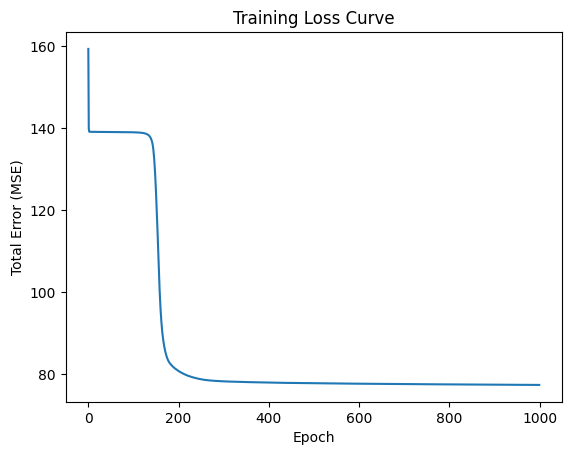

In [16]:
errors = []
for epoch in range(1000):
    total_error = 0
    for iter_training_data in range(len(training_data)):
        # --------------------NEURAL NETWORK PREDICTION-------------------------------------
        #       0   
        #   0---0---0
        #   0---0---0---0 
        #   0---0---0---0----0   (0-1) live or death
        #   0---0---0---0
        #   0---0---0
        #       0
        layer_2 = np.dot(training_data[iter_training_data], weights_layer_1_2) + bias_1
        layer_2_activated = relu(layer_2)

        layer_3 = np.dot(layer_2_activated, weights_layer_2_3) + bias_2
        layer_3_activated = relu(layer_3)

        layer_4 = np.dot(layer_3_activated, weights_layer_3_4) + bias_3
        layer_4_activated = relu(layer_4)
        
        pred = np.dot(layer_4_activated, weights_layer_4_5) + bias_4
        pred_activated = sigmoid(pred)
        
        error = pred_activated - training_goal[iter_training_data]

        total_error += np.sum(error**2)  # MSE (Mean Squared Error) (середньоквадратична помилка)

        #print("NEURAL NETWORK PREDICTION", pred_activated)
        #print("error", error)
        #print("Total_error", total_error)
        #print("*"*100)

        # --------------------NEURAL NETWORK PREDICTION-------------------------------------
        # --------------------NEURAL NETWORK backpropagation-------------------------------- 
        # error of output layer
        layer_5_delta = error * sigmoid_derivative(pred_activated)
        # наскільки сильно поправити вихідний нейрон

        layer_4_error = np.dot(layer_5_delta, weights_layer_4_5.T) # create a transport matrix for easy convertion
        # Ми беремо помилку на виході і розкидаємо її назад по всіх нейронах прихованого шару
        layer_4_delta = layer_4_error * relu_derivative(layer_4)
        # вирішуємо які звязки винні в таких вагах, бо Relu обрізає все що менще 0

        layer_3_error = np.dot(layer_4_delta, weights_layer_3_4.T) # create a transport matrix for easy convertion
        # Ми беремо помилку на виході і розкидаємо її назад по всіх нейронах прихованого шару
        layer_3_delta = layer_3_error * relu_derivative(layer_3)
        # вирішуємо які звязки винні в таких вагах, бо Relu обрізає все що менще 0

        layer_2_error = np.dot(layer_3_delta, weights_layer_2_3.T) # create a transport matrix for easy convertion
        # Ми беремо помилку на виході і розкидаємо її назад по всіх нейронах прихованого шару
        layer_2_delta = layer_2_error * relu_derivative(layer_2)
        # вирішуємо які звязки винні в таких вагах, бо Relu обрізає все що менще 0

        weight_delta_4_5 = np.dot(layer_4_activated.T, layer_5_delta)
        weights_layer_4_5 -= weight_delta_4_5 * alpha
        bias_4 -= alpha * layer_5_delta

        weight_delta_3_4 = np.dot(layer_3_activated.T, layer_4_delta)
        weights_layer_3_4 -= weight_delta_3_4 * alpha
        bias_3 -= alpha * layer_4_delta
        
        weight_delta_2_3 = np.dot(layer_2_activated.T, layer_3_delta)
        weights_layer_2_3 -= weight_delta_2_3 * alpha
        bias_2 -= alpha * layer_3_delta
    
        inp_vector = np.array(training_data[iter_training_data]).reshape(-1,1)  # make input as a colown
        weight_delta_1_2 = np.dot(inp_vector, layer_2_delta)
    
        weights_layer_1_2 -= weight_delta_1_2 * alpha
        bias_1 -= alpha * layer_2_delta

        # --------------------NEURAL NETWORK backpropagation-------------------------------- 

        
        # # --------------------NEURAL NETWORK backpropagation-------------------------------- 
        # # error of output layer
        # layer_4_delta = error * sigmoid_derivative(pred_activated)
        # # наскільки сильно поправити вихідний нейрон
    
        # layer_3_error = np.dot(layer_4_delta, weights_layer_3_4.T) # create a transport matrix for easy convertion
        # # Ми беремо помилку на виході і розкидаємо її назад по всіх нейронах прихованого шару
        # layer_3_delta = layer_3_error * relu_derivative(layer_3)
        # # вирішуємо які звязки винні в таких вагах, бо Relu обрізає все що менще 0

        # layer_2_error = np.dot(layer_3_delta, weights_layer_2_3.T) # create a transport matrix for easy convertion
        # # Ми беремо помилку на виході і розкидаємо її назад по всіх нейронах прихованого шару
        # layer_2_delta = layer_2_error * relu_derivative(layer_2)
        # # вирішуємо які звязки винні в таких вагах, бо Relu обрізає все що менще 0

        # weight_delta_3_4 = np.dot(layer_3_activated.T, layer_4_delta)
        # weights_layer_3_4 -= weight_delta_3_4 * alpha
        # bias_3 -= alpha * layer_4_delta
        
        # weight_delta_2_3 = np.dot(layer_2_activated.T, layer_3_delta)
        # weights_layer_2_3 -= weight_delta_2_3 * alpha
        # bias_2 -= alpha * layer_3_delta
    
        # inp_vector = np.array(training_data[iter_training_data]).reshape(-1,1)  # make input as a colown
        # weight_delta_1_2 = np.dot(inp_vector, layer_2_delta)
    
        # weights_layer_1_2 -= weight_delta_1_2 * alpha
        # bias_1 -= alpha * layer_2_delta

        # # --------------------NEURAL NETWORK backpropagation-------------------------------- 

    errors.append(total_error)
    
    if total_error < 0.001:
        break

print("Finished")


plt.plot(errors)
plt.xlabel("Epoch")
plt.ylabel("Total Error (MSE)")
plt.title("Training Loss Curve")
plt.savefig(fr"{dir_path}\docs\loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()


In [17]:
# 5. Evaluation

In [18]:
def threshold(z, t=0.8):
    return np.where(z > t, 1, 0)

Final total error: 34
Accuracy: 0.7622377622377622


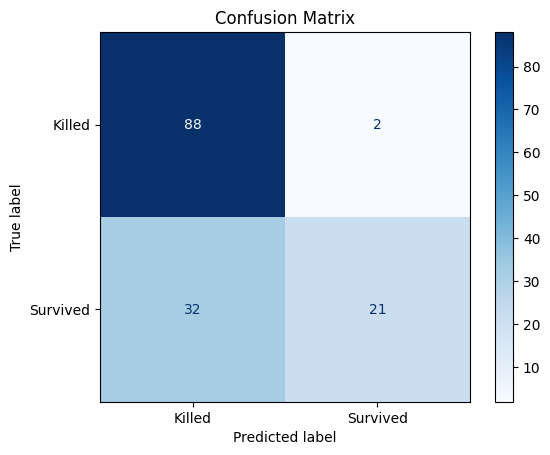

In [19]:
# check how good the neural network is working 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_labels = []
true_labels = []
total_error = 0
correct_predictions = 0
for iter_training_data in range(len(testing_data)):

    # --------------------NEURAL NETWORK PREDICTION-------------------------------------
    layer_2 = np.dot(testing_data[iter_training_data], weights_layer_1_2) + bias_1
    layer_2_activated = relu(layer_2)

    layer_3 = np.dot(layer_2_activated, weights_layer_2_3) + bias_2
    layer_3_activated = relu(layer_3)

    layer_4 = np.dot(layer_3_activated, weights_layer_3_4) + bias_3
    layer_4_activated = relu(layer_4)
    
    pred = np.dot(layer_4_activated, weights_layer_4_5) + bias_4
    pred_activated = threshold(pred)[0]
    
    error = pred_activated - testing_goal[iter_training_data]

    total_error += np.sum(error**2)  # MSE (Mean Squared Error) (середньоквадратична помилка)

    # перевірка класифікації
    predicted_class = pred_activated
    true_class = testing_goal[iter_training_data]

    
    if predicted_class == true_class:
        correct_predictions += 1

    predicted_labels.append(predicted_class)
    true_labels.append(true_class)

    # print("predicted_class", predicted_class)
    # print("true_class",true_class)
    
    # print("testing_data[iter_training_data]", testing_data[iter_training_data], "---> ", testing_goal[iter_training_data])
    # print("NEURAL NETWORK PREDICTION", pred_activated)
    # print("correct_predictions", correct_predictions)
    # print("error", error)
    # print("Total_error", total_error)
    # print("*"*100)

# фінальні метрики
accuracy = correct_predictions / len(testing_data)
print("Final total error:", total_error)
print("Accuracy:", accuracy)

# confusion matrix plot
cm = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Killed", "Survived", ])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig(fr"{dir_path}\docs\confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# 0.7762237762237763
# 0.7832167832167832

In [62]:
import numpy as np
from sklearn.model_selection import train_test_split

# Формуємо X (вхідні дані)
X = np.array([
    titanic_ds["Pclass"],
    titanic_ds["Sex"],
    titanic_ds["Age"] / 100,
    titanic_ds["Fare"] / 100,
    titanic_ds["FamilySize"] / 10
]).T   # ← Transpose, щоб рядки стали прикладами

# Формуємо y (вихід — 0 або 1)
y = np.array(titanic_ds["Survived"]).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(y_train.shape)
print(np.unique(y_train))



(571, 1)
[0 1]


In [70]:
# try to get better results with library 
#print("testing_data",len(testing_data))
#print("testing_goal",len(testing_goal))
#print("training_data",len(training_data))
#print("training_goal",len(training_goal))
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(8, activation='relu',input_shape=(5,)),      # перший прихований шар
    layers.Dense(5, activation='relu'),       # другий прихований шар
    layers.Dense(3, activation='relu'),       # другий прихований шар
    layers.Dense(1, activation='sigmoid')     # вихідний шар
])


In [71]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.0005),
#     loss=keras.losses.BinaryCrossentropy(),
#     metrics=[keras.metrics.Accuracy(), keras.metrics.Precision(), keras.metrics.Recall()]
# )

Epoch 1/100
29/29 - 0s - 7ms/step - accuracy: 0.8224 - loss: 0.4031 - val_accuracy: 0.8087 - val_loss: 0.4518
Epoch 2/100
29/29 - 0s - 6ms/step - accuracy: 0.8246 - loss: 0.3980 - val_accuracy: 0.8000 - val_loss: 0.4597
Epoch 3/100
29/29 - 0s - 6ms/step - accuracy: 0.8180 - loss: 0.3994 - val_accuracy: 0.8087 - val_loss: 0.4543
Epoch 4/100
29/29 - 0s - 6ms/step - accuracy: 0.8180 - loss: 0.3995 - val_accuracy: 0.8087 - val_loss: 0.4530
Epoch 5/100
29/29 - 0s - 5ms/step - accuracy: 0.8180 - loss: 0.3987 - val_accuracy: 0.8087 - val_loss: 0.4571
Epoch 6/100
29/29 - 0s - 6ms/step - accuracy: 0.8202 - loss: 0.3993 - val_accuracy: 0.8087 - val_loss: 0.4522
Epoch 7/100
29/29 - 0s - 6ms/step - accuracy: 0.8136 - loss: 0.3995 - val_accuracy: 0.8087 - val_loss: 0.4547
Epoch 8/100
29/29 - 0s - 6ms/step - accuracy: 0.8311 - loss: 0.3990 - val_accuracy: 0.8000 - val_loss: 0.4524
Epoch 9/100
29/29 - 0s - 5ms/step - accuracy: 0.8180 - loss: 0.4020 - val_accuracy: 0.8087 - val_loss: 0.4535
Epoch 10/1

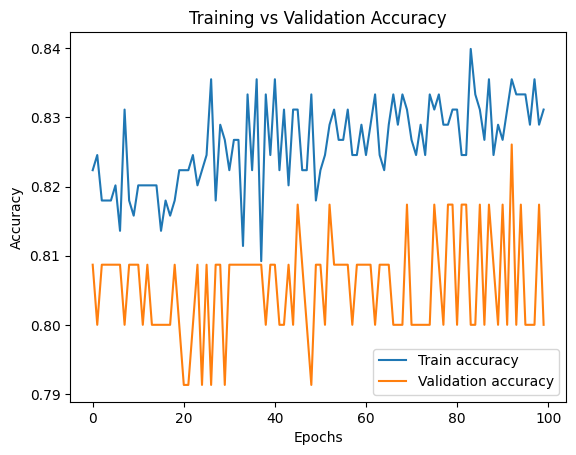

In [81]:


history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=2
)

plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [82]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("accuracy: ", accuracy)



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7762 - loss: 0.4908
accuracy:  0.7762237787246704
